# Anomaly Detection

An unsupervised approach for detecting anomalies can be based on one-class learning. The underlying assumption in one-class learning is that the data given have only normal examples.
So, effectively, we can think that by having olny normal observations, we can build a model which has a normal behavior.
There are many ways with which someone can approach this one-class learning:
* Through density estimation, so train a probabilistic model and represent the probability distribution over the instance space.
* By training an one-class SVM, which basically tries to fit the data.
* By training an auto-encoder.


#### Anomaly Detection using an auto-encoder: 
In an auto-encoder, someone tries to come up with a lower representation of the data, a compressed representation in other words (bottleneck effect), and reconstruct then the original data. So, in an anomaly detection scenario someone can build and train an autoencoder with some training data (this will be the model with the normal behavior) and then, at the test time, can check how closely a test example fits this model with the normal behavior.

So, someone could think of it, that by checking the reconstruction error, if the example is normal should fall into something that is similar to the training data, having a small reconstruction error. Otherwise, test examples with high reconstruction error are more likely to be anomalies.

#### Followed Logic in the current project:
* We build and train an auto-encoder.
* We predict on the training data and find the MAE loss between the original training and the corresponding predicted training values. 
* The maximum MAE loss value is determined to be the threshold for anomaly detection.
* If the reconstruction loss for a test sample is greater than this threshold, then we can conclude that the model is seeing a pattern that it isn't familiar with. We will label this sample as an anomaly.

### Import the appropriate packages

In [181]:
import numpy as np
from pandas import read_csv

from tensorflow import keras
from tensorflow.keras import layers

from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import dates as md

from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dropout
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

### Collect the Timeseries data

In [183]:
root_path = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

train_path = "artificialNoAnomaly/art_daily_small_noise.csv"
train_file = root_path + train_path
train_df = read_csv(train_file)

test_path = "artificialWithAnomaly/art_daily_jumpsup.csv"
test_file = root_path + test_path
test_df = read_csv(test_file)

In [184]:
print(train_df)

                timestamp      value
0     2014-04-01 00:00:00  18.324919
1     2014-04-01 00:05:00  21.970327
2     2014-04-01 00:10:00  18.624806
3     2014-04-01 00:15:00  21.953684
4     2014-04-01 00:20:00  21.909120
...                   ...        ...
4027  2014-04-14 23:35:00  20.211195
4028  2014-04-14 23:40:00  20.531041
4029  2014-04-14 23:45:00  19.032127
4030  2014-04-14 23:50:00  21.798801
4031  2014-04-14 23:55:00  18.682620

[4032 rows x 2 columns]


### Visualize the data

*   Training Dataset without Anomalies 
*   Test Dataset with Anomalies


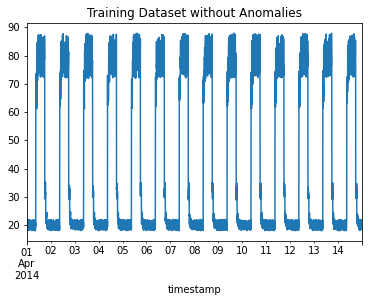

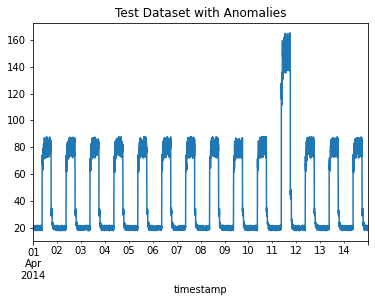

In [294]:
train_times_series = read_csv(train_file, header=0, index_col=0, parse_dates=True, squeeze=True)
train_times_series.plot()
plt.title('Training Dataset without Anomalies')
plt.show()

test_times_series = read_csv(test_file, header=0, index_col=0, parse_dates=True, squeeze=True)
test_times_series.plot()
plt.title('Test Dataset with Anomalies')
plt.show()

### Data preprocessing

Rescale the data. Two methods are usually well known for rescaling data:

*   Normalization
*   Standardization

In anomaly detection scenarios, standardization is mainly used.
 
**Note:** We have values for 14 days; one value every 5 minutes is recorded per day. 
* 24*60/5 = 288 timesteps per day
* 288*14 = 4032 total data points

In [229]:
#Standardization rescales data to have a mean (μ) of 0 and standard deviation (σ) of 1 (unit variance).
def standardize_train(values):    # y = (x - mean) / standard_deviation 
    mean = np.mean(values)
    values -= mean
    std = np.std(values)
    values /= std
    return values, mean, std         

#Normalization rescales the values into a range of [0,1]. This step is very important when dealing with parameters of 
#different units and scales and can help the model converge faster. However, the outliers from the data set are lost.
def normalize(values): # y = (x - min) / (max - min)
    max=np.max(values)
    min=np.min(values)
    values -= min
    dif= max-min
    values /= dif    
    return values

def standardize_test(values, mean, std):
    values -= mean
    values /= std
    return values  

In [231]:
# Get the `value` column from the training dataframe.
trainNumbers = train_df['value']
training_value = list(dict.fromkeys(trainNumbers))

# Get the `value` column from the test dataframe.
testNumbers = test_df['value']
test_value = list(dict.fromkeys(testNumbers))

# Standarize training values and save the mean and std we get, for normalizing test data.
training_value, training_mean, training_std = standardize_train(training_value)
print(training_value)
#len(training_value)   # our data points in total

#Standardize test values
test_value = standardize_test(test_value, training_mean, training_std)
print(test_value)

[-0.85893509 -0.72908344 -0.84825292 ... -0.83374388 -0.73519331
 -0.84619354]
[-0.80777203 -0.7814277  -0.80063403 ... -0.77908102 -0.86145439
 -0.73290125]


### Create sequences
Create sequences from the training and test data, combining the timestamp corresponding values.

In [307]:
time_steps = 288 # because we have 288 values per day

def create_sequences(values, time_steps):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    y = np.expand_dims(output, axis=2)
    return y

# Create sequences from train values.
x_train = create_sequences(training_value, time_steps)
print("Training input shape: ", x_train.shape)

# Create sequences from test values.
x_test = create_sequences(test_value, time_steps)
print("Test input shape: ", x_test.shape)

Training input shape:  (3744, 288, 1)
Test input shape:  (3744, 288, 1)


### Define an auto-encoder architecture

In [189]:
input_ = Input(shape=(x_train.shape[1], x_train.shape[2]))
#input_ = Input(shape=(288, 1))

def auto_encode(input_):
    #encoder
    conv1 = Conv1D(32, kernel_size=7, activation='relu', padding='same')(input_)
    pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)
    pool1= Dropout(0.3)(pool1)
    conv2 = Conv1D(16, kernel_size=7, activation='relu', padding='same')(pool1)
    encoded = MaxPooling1D(pool_size=2, padding='same')(conv2)
    #encoded= Dropout(0.2)(encoded)

    #decoder
    conv4 = Conv1D(16, kernel_size=7, activation='relu', padding='same')(encoded)
    up1 = UpSampling1D(size=2)(conv4)
    up1= Dropout(0.3)(up1)
    conv5 = Conv1D(32, kernel_size=7, activation='relu', padding='same')(up1) 
    up2 = UpSampling1D(size=2)(conv5)
    #up2= Dropout(0.2)(up2) 
    decoded = Conv1D(1, kernel_size=7, activation='sigmoid', padding='same')(up2)
    return decoded

* **Build the model**

In [190]:
#Build the model
model = Model(input_, auto_encode(input_)) #create an object first
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 288, 1)            0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 288, 32)           256       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 144, 32)           0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 144, 32)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 144, 16)           3600      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 72, 16)            0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 72, 16)            1808

* **Compile and train the model**

In [191]:
#Compile the model and train
keras_callbacks = [
      #ModelCheckpoint(CHECKPOINT_PATH, verbose=1, save_best_only=False),
      ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, min_lr=1e-9, mode='auto', verbose=2),
      EarlyStopping(monitor='val_loss', patience=5, mode='min'),
      #PlotLossesKeras()
]
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=1e-4))
model_train = model.fit(x_train, x_train, epochs=100, batch_size=128, verbose=1, validation_split=0.2, callbacks=keras_callbacks)

Train on 2995 samples, validate on 749 samples
Epoch 1/100
2995/2995 [==============================] - 4s 1ms/step - loss: 1.2386 - val_loss: 1.2299
Epoch 2/100
2995/2995 [==============================] - 3s 1ms/step - loss: 1.1856 - val_loss: 1.1620
Epoch 3/100
2995/2995 [==============================] - 3s 1ms/step - loss: 1.0520 - val_loss: 0.9855
Epoch 4/100
2995/2995 [==============================] - 3s 1ms/step - loss: 0.8312 - val_loss: 0.7489
Epoch 5/100
2995/2995 [==============================] - 3s 1ms/step - loss: 0.6595 - val_loss: 0.6192
Epoch 6/100
2995/2995 [==============================] - 3s 1ms/step - loss: 0.5529 - val_loss: 0.5187
Epoch 7/100
2995/2995 [==============================] - 3s 1ms/step - loss: 0.4804 - val_loss: 0.4671
Epoch 8/100
2995/2995 [==============================] - 3s 1ms/step - loss: 0.4543 - val_loss: 0.4508
Epoch 9/100
2995/2995 [==============================] - 3s 1ms/step - loss: 0.4455 - val_loss: 0.4441
Epoch 10/100
2995/2995 [==

* **Plot the training and validation loss**

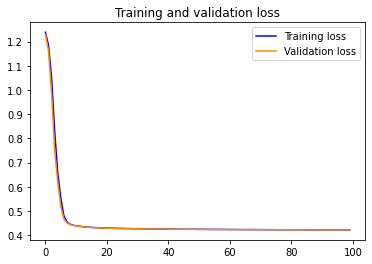

In [241]:
#plot the loss between training and validation 
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'darkorange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Detecting Anomalies

We detect any abnormalities, by determining how well our model can reconstruct the input test data.

In [308]:
# Get the train mean absolute error (mae) loss.
x_train_prediction = model.predict(x_train)
train_loss = np.mean(np.abs(x_train_prediction - x_train), axis=1)

# Get reconstruction loss threshold.
threshold = np.max(train_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.6074680930783575


In [309]:
# Get the test mean absolute error (mae) loss.
x_test_prediction = model.predict(x_test)
test_loss = np.mean(np.abs(x_test_prediction - x_test), axis=1)
test_loss = test_loss.reshape((-1))

# Detect all the samples which are anomalies.
anomalies = (test_loss > threshold).tolist()
print("Number of anomaly samples: ", np.sum(anomalies))

Number of anomaly samples:  443


In [310]:
#Find the corresponding indices (timestamps) from the original test dataset, of each anomaly.
anomalies_indices = []
for i in range(time_steps - 1, len(test_value) - time_steps + 1):
    time_series = range(i - time_steps + 1, i)
    if all([anomalies[j] for j in time_series]):
        anomalies_indices.append(i)

### Plot an overlay of the anomalies on the original test data plot.

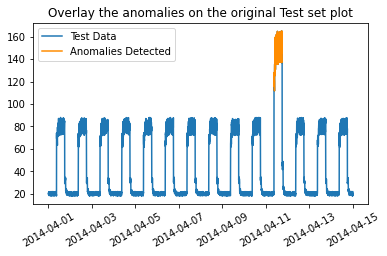

In [313]:
#Create a dataframe containing the anomalies in the test dataset
anomalies_in_test_df = test_df.iloc[anomalies_indices, :]
plt.subplots_adjust(bottom=0.25)
plt.xticks(rotation=30)

#Plot the original test data
dates = test_df["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = test_df["value"].to_list()
plt.plot(dates, values, label="Test Data")

#Overlay the anomalies on the original test data
dates = anomalies_in_test_df["timestamp"].to_list()
dates = [datetime.strptime(x, "%Y-%m-%d %H:%M:%S") for x in dates]
values = anomalies_in_test_df["value"].to_list()
plt.plot(dates, values, label="Anomalies Detected", color="darkorange")

plt.title('Overlay the anomalies on the original Test set plot')
plt.legend()
plt.show()